# Setup

In [ ]:
import pandas as pd
import scipy
import copy
import numpy as np
import plotly.express as px
import matplotlib.pyplot as plt
import plotly.express as px

from scipy import stats

from sklearn.model_selection import train_test_split

In [ ]:
def generate_gaussian(rho, sample_size=2000):
  mean = np.zeros(2)
  E = np.zeros(shape=(2, 2)) + rho
  E[0, 0] = 1
  E[1, 1] =1

  D = np.random.multivariate_normal(mean=mean, cov=E, size=(sample_size, )).T

  # Generating Train and test data
  shuf_indexes = np.random.permutation(sample_size)

  train_p = 0.75
  n_train = int(D.shape[1] * train_p)
  n_test = D.shape[1] - n_train

  train_D = D[:, shuf_indexes[:n_train]]
  test_D = D[:, shuf_indexes[n_train:]]

  return train_D, test_D


def GT_gaussian_density(points, rho):
  x = points[0]
  y = points[1]

  c_uv = (1/np.sqrt(1 - rho**2)) * np.exp( ((-1 * rho**2 * x**2 * y**2) - (2*rho*x*y)) / (2*(1 - rho**2)) )
  f_x = stats.norm.pdf(x)
  f_y = stats.norm.pdf(y)

  return c_uv * f_x * f_y

In [ ]:
# Marshal and Olkin
def clayton_sample(theta):
  alpha = 1 / theta
  beta = 1
  V = np.random.gamma(shape=alpha, scale=beta)
  R = np.random.exponential(scale=1, size=2)
  t = R / V
  U = (1 + t) ** (-1/theta)
  return U

# Generate Clayton Copula with N(0,1) margins
def generate_clayton_sample(theta, sample_size=2000):
  X = []
  Y = []
  for _ in range(sample_size):
    U = clayton_sample(theta)
    X.append(stats.norm.ppf(U[0]))
    Y.append(stats.norm.ppf(U[1]))

  D = np.concatenate((X, Y)).reshape((2, -1))

  # Generating Train and test data
  shuf_indexes = np.random.permutation(sample_size)

  train_p = 0.75
  n_train = int(D.shape[1] * train_p)
  n_test = D.shape[1] - n_train

  train_D = D[:, shuf_indexes[:n_train]]
  test_D = D[:, shuf_indexes[n_train:]]

  return train_D, test_D

In [ ]:
# Marshal and Olkin
def frank_sample(theta):
  p = 1 - np.exp(-theta)
  V = stats.logser.rvs(p)
  R = np.random.exponential(scale=1, size=2)
  t = R / V
  U = -1/theta * np.log( 1 - ( (1 - np.exp(-theta)) * (np.exp(-t)) ) )
  return U

# Generate Frank Copula with N(0,1) margins
def generate_frank_sample(theta, sample_size=2000):
  X = []
  Y = []
  for _ in range(sample_size):
    U = frank_sample(theta)
    X.append(stats.norm.ppf(U[0]))
    Y.append(stats.norm.ppf(U[1]))

  D = np.concatenate((X, Y)).reshape((2, -1))

  # Generating Train and test data
  shuf_indexes = np.random.permutation(sample_size)

  train_p = 0.75
  n_train = int(D.shape[1] * train_p)
  n_test = D.shape[1] - n_train

  train_D = D[:, shuf_indexes[:n_train]]
  test_D = D[:, shuf_indexes[n_train:]]

  return train_D, test_D

In [ ]:
def visualize_data(D):
  _, ax = plt.subplots(figsize=(5.5, 5))

  ax.scatter(
      D[0],
      D[1],
      s=80,
      edgecolor='k',
      alpha=0.5
  )

  plt.show()

# ACNet

## imports

In [ ]:
!git clone https://github.com/lingchunkai/ACNet

Cloning into 'ACNet'...
remote: Enumerating objects: 60, done.
remote: Counting objects: 100% (60/60), done.
remote: Compressing objects: 100% (33/33), done.
remote: Total 60 (delta 24), reused 56 (delta 20), pack-reused 0
Receiving objects: 100% (60/60), 78.08 KiB | 19.52 MiB/s, done.
Resolving deltas: 100% (24/24), done.


In [ ]:
%cd ACNet

/content/ACNet


In [ ]:
!pip install sacred

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.9/107.9 kB 3.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.5/188.5 kB 19.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 4.7 MB/s eta 0:00:00
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13706 sha256=11a0590142e06d37d633cfa7eb6942b93c6339fd6b7c96bb523d499c2dbdde8f
  Stored in directory: /root/.cache/pip/wheels/fc/ab/d4/5da2067ac95b36618c629a5f93f809425700506f72c9732fac
Successfully built docopt


In [ ]:
from main import Copula
from dirac_phi import DiracPhi
import pickle
#from sacred import Experiment
from train import load_data, load_log_ll
import torch
#from sacred.observers import FileStorageObserver#

In [ ]:
from torch.autograd import Function, gradcheck
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pickle
import os
from main import sample

In [ ]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

In [ ]:
torch.set_default_tensor_type(torch.DoubleTensor)

In [ ]:
from scipy.stats import bootstrap

In [ ]:
def get_optim(name, net, args):
    if name == 'SGD':
        optimizer = optim.SGD(net.parameters(), args['lr'], args['momentum'])
    elif name == 'Adam':
        # TODO: add in more. Note: we do not use this in the paper.
        optimizer = optim.Adam(net.parameters(), args['lr'])
    elif name == 'RMSprop':
        # TODO: add in more. Note: we do not use this in the paper.
        optimizer = optim.RMSprop(net.parameters(), args['lr'])

    return optimizer


def expt(train_data, val_data,
         net,
         optim_name,
         optim_args,
         identifier,
         num_epochs=1000,
         batch_size=100,
         chkpt_freq=50,
         ):

    ''' if not os.path.exists('./checkpoints/%s'):
      os.mkdir('./checkpoints/%s' % identifier)
    if not os.path.exists('./sample_figs/%s'):
      os.mkdir('./sample_figs/%s' % identifier) '''

    train_loader = DataLoader(
        train_data, batch_size=batch_size, shuffle=True)

    # IMPORTANT: for this experiment, we did *not* perform hyperparameter tuning.
    # Hence, the `validation loss' here is essentially `test` loss.
    val_loader = DataLoader(
        val_data, batch_size=1000000, shuffle=True)

    optimizer = get_optim(optim_name, net, optim_args)

    train_loss_per_epoch = []

    for epoch in range(num_epochs):
        loss_per_minibatch = []
        for i, data in enumerate(train_loader, 0):
            optimizer.zero_grad()

            #d = data.clone().detach().requires_grad_(True)
            d = torch.tensor(data, requires_grad=True)
            p = net(d, mode='pdf')

            logloss = -torch.sum(torch.log(p))
            reg_loss = logloss
            reg_loss.backward()
            scalar_loss = (reg_loss/p.numel()).detach().numpy().item()

            loss_per_minibatch.append(scalar_loss)
            optimizer.step()

        train_loss_per_epoch.append(np.mean(loss_per_minibatch))
        print('Training loss at epoch %s: %s' %
              (epoch, train_loss_per_epoch[-1]))

        if epoch % chkpt_freq == 0:
            ''' print('Checkpointing')
            torch.save({
                'epoch': epoch,
                'model_state_dict': net.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': logloss,
            }, './checkpoints/%s/epoch%s' % (identifier, epoch)) '''

            """
            if args.dims == 2:
                print('Scatter sampling')
                samples = sample(net, 2, 1000)
                plt.scatter(samples[:, 0], samples[:, 1])
                plt.savefig('./sample_figs/%s/epoch%s.png' %
                            (identifier, epoch))
                plt.clf()
            else:
                print('Not doign scatter plot, dims > 2')
            """

            print('Evaluating validation/test loss.')
            for j, val_data in enumerate(val_loader, 0):
                net.zero_grad()
                val_p = net(val_data, mode='pdf')
                val_loss = -torch.mean(torch.log(val_p))
            print('Average validation/test loss %s' % val_loss)

        if epoch == num_epochs - 1:
            print('Scatter sampling')
            samples = sample(net, 2, 1000)
            plt.scatter(samples[:, 0], samples[:, 1])
            plt.show()
    return val_p

## FIX PARAMS

In [ ]:
optim_name = 'SGD'
optim_args = \
    {
        'lr': 1e-5,
        'momentum': 0.9
    }
#num_epochs = 10000000
num_epochs = 5000
batch_size = 200
chkpt_freq = 50

Phi = DiracPhi
phi_name = 'DiracPhi'

# Initial parameters.
depth = 2
widths = [10, 10]
lc_w_range = (0, 1.0)
shift_w_range = (0., 2.0)

identifier_id = 'None'

## Gauss $\rho = 0.1$

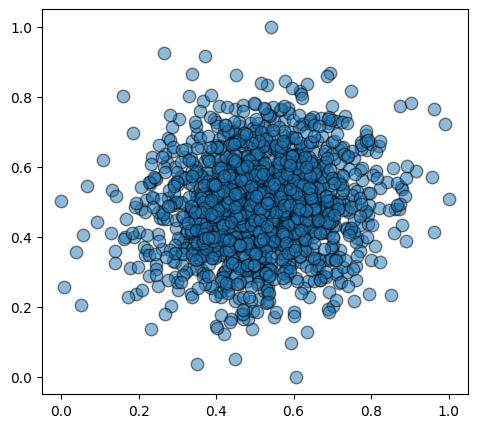

In [ ]:
np.random.seed(30091985)

rho = 0.1
train_D, test_D = generate_gaussian(rho)
train_D = scaler.fit_transform(train_D.T).T
test_D = scaler.fit_transform(test_D.T).T

visualize_data(train_D)

In [ ]:
train_data = torch.tensor(train_D).requires_grad_(True).T
test_data = torch.tensor(test_D).requires_grad_(True).T

[tensor([0.8613, 0.2404, 0.0849, 1.4906, 1.1098, 0.0844, 0.8818, 1.0981, 0.7653,
        1.6227]), tensor([1.7048, 1.4406, 0.1163, 1.5089, 0.9076, 1.6068, 0.4913, 0.6153, 1.8383,
        1.5337])] [tensor([[0.7599, 0.1671, 0.2034, 0.3589, 0.3264, 0.0079, 0.6329, 0.2579, 0.7110,
         0.8047],
        [0.6959, 0.7039, 0.8291, 0.0120, 0.4417, 0.5097, 0.7960, 0.6204, 0.9946,
         0.8655],
        [0.0963, 0.0101, 0.3890, 0.0290, 0.6642, 0.5248, 0.0401, 0.9522, 0.3693,
         0.4693],
        [0.2860, 0.4796, 0.1975, 0.0143, 0.5841, 0.2386, 0.8346, 0.0236, 0.8180,
         0.6125],
        [0.8425, 0.3247, 0.2106, 0.6097, 0.2505, 0.2717, 0.2474, 0.8517, 0.0383,
         0.8478],
        [0.1260, 0.5570, 0.8618, 0.7951, 0.9917, 0.2214, 0.2309, 0.7617, 0.2058,
         0.8709],
        [0.5760, 0.5245, 0.5058, 0.8629, 0.7104, 0.4571, 0.8943, 0.6736, 0.5529,
         0.8313],
        [0.1843, 0.7413, 0.8138, 0.0214, 0.6120, 0.6863, 0.5445, 0.7919, 0.7791,
         0.7939],
        [0

<ipython-input-14-0cf8dd5cba73>:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  d = torch.tensor(data, requires_grad=True)


A saída de streaming foi truncada nas últimas 5000 linhas.
Training loss at epoch 5194: -0.35204281420513683
Training loss at epoch 5195: -0.3536153647204965
Training loss at epoch 5196: -0.34986104398237494
Training loss at epoch 5197: -0.34902827408037335
Training loss at epoch 5198: -0.34772080553518975
Training loss at epoch 5199: -0.34942739963286157
Training loss at epoch 5200: -0.34441917819084866
Evaluating validation/test loss.
Average validation/test loss tensor(-0.0640, grad_fn=<NegBackward0>)
Training loss at epoch 5201: -0.34731503046911677
Training loss at epoch 5202: -0.3556267679755145
Training loss at epoch 5203: -0.3508491390760972
Training loss at epoch 5204: -0.3485080271514325
Training loss at epoch 5205: -0.35130124320095124
Training loss at epoch 5206: -0.3477814425881169
Training loss at epoch 5207: -0.3543622200742025
Training loss at epoch 5208: -0.3554427358680632
Training loss at epoch 5209: -0.3509936305360169
Training loss at epoch 5210: -0.348488541095914

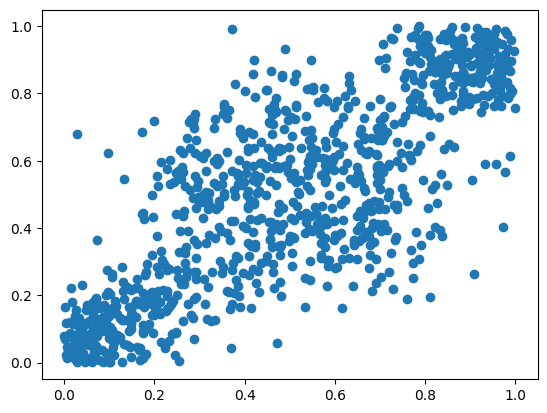

In [ ]:
phi = Phi(depth, widths, lc_w_range, shift_w_range)
net = Copula(phi)
yhat = expt(train_data, test_data, net, optim_name, optim_args, identifier_id, num_epochs, batch_size, chkpt_freq)

In [ ]:
yhat = -np.log(yhat.detach().numpy())
nll = np.mean(yhat)
res = bootstrap((yhat,), np.mean)
rmean = res.bootstrap_distribution.mean()
low = res.confidence_interval.low
high = res.confidence_interval.high
dev1 = high - rmean
dev2 = rmean - low
dev = dev1 if dev1 > dev2 else dev2
rmean, res.standard_error, res.confidence_interval
print(f'NLL: {nll:.4f} RMean: {rmean:.4f} IC: ({low:.4f},{high:.4f}) Notation: {rmean:.2f}$\pm${dev:.2f}')

NLL: -0.0617 RMean: -0.0615 IC: (-0.1366,0.0265) Notation: -0.06$\pm$0.09


## Gauss $\rho = 0.5$

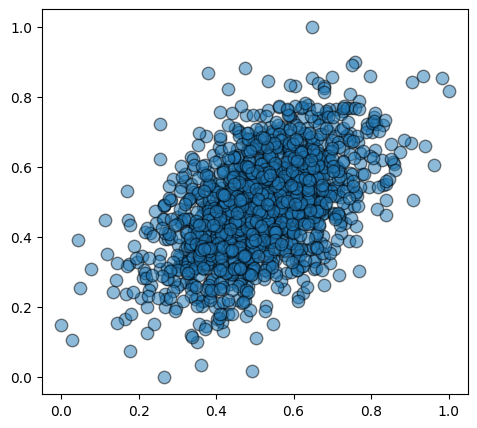

In [ ]:
np.random.seed(30091985)

rho = 0.5
train_D, test_D = generate_gaussian(rho)
train_D = scaler.fit_transform(train_D.T).T
test_D = scaler.fit_transform(test_D.T).T

visualize_data(train_D)

[tensor([0.9327, 0.3351, 0.7115, 0.8823, 1.5745, 1.3508, 1.9824, 0.2022, 0.7318,
        1.7317]), tensor([0.5155, 0.5845, 1.9046, 0.7274, 1.9067, 0.3540, 1.7089, 0.8840, 1.1114,
        1.1426])] [tensor([[0.3532, 0.7657, 0.6764, 0.9094, 0.9301, 0.5996, 0.6234, 0.3900, 0.6686,
         0.2486],
        [0.2160, 0.5168, 0.0828, 0.0368, 0.3309, 0.5768, 0.5094, 0.9726, 0.8716,
         0.2622],
        [0.8927, 0.4108, 0.1057, 0.3979, 0.3109, 0.4259, 0.0301, 0.8838, 0.4683,
         0.0387],
        [0.4730, 0.1865, 0.1692, 0.1313, 0.3947, 0.4633, 0.4074, 0.3071, 0.2646,
         0.4612],
        [0.5507, 0.6981, 0.8903, 0.4374, 0.5292, 0.0752, 0.3560, 0.8763, 0.7670,
         0.4885],
        [0.3280, 0.7676, 0.1954, 0.8367, 0.1019, 0.0837, 0.6097, 0.0323, 0.9395,
         0.8088],
        [0.3196, 0.3836, 0.9904, 0.6540, 0.8462, 0.8463, 0.6486, 0.6652, 0.1451,
         0.3839],
        [0.8149, 0.0253, 0.5471, 0.1817, 0.5431, 0.1342, 0.3593, 0.9189, 0.8995,
         0.0440],
        [0

<ipython-input-14-0cf8dd5cba73>:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  d = torch.tensor(data, requires_grad=True)


A saída de streaming foi truncada nas últimas 5000 linhas.
Training loss at epoch 5194: -0.5577921355668519
Training loss at epoch 5195: -0.5597335774770611
Training loss at epoch 5196: -0.5511696709443791
Training loss at epoch 5197: -0.5588043467020671
Training loss at epoch 5198: -0.5575536752643002
Training loss at epoch 5199: -0.5505966993791793
Training loss at epoch 5200: -0.5558837588813668
Evaluating validation/test loss.
Average validation/test loss tensor(-0.2956, grad_fn=<NegBackward0>)
Training loss at epoch 5201: -0.553876449498844
Training loss at epoch 5202: -0.5458677838376367
Training loss at epoch 5203: -0.5502354310008747
Training loss at epoch 5204: -0.5512523948306338
Training loss at epoch 5205: -0.559125942326332
Training loss at epoch 5206: -0.5507389816797008
Training loss at epoch 5207: -0.5490330854023515
Training loss at epoch 5208: -0.5517080240556342
Training loss at epoch 5209: -0.5543670388076036
Training loss at epoch 5210: -0.5510408702011258
Training

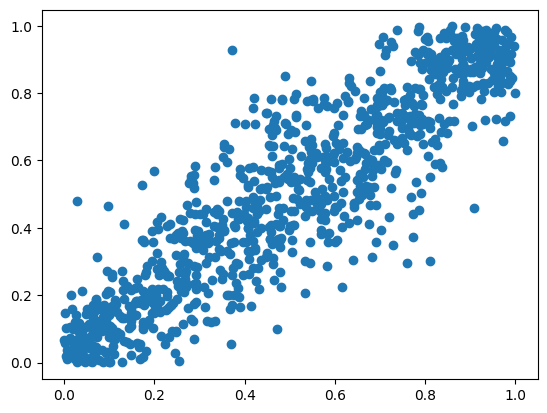

In [ ]:
train_data = torch.tensor(train_D).requires_grad_(True).T
test_data = torch.tensor(test_D).requires_grad_(True).T

phi = Phi(depth, widths, lc_w_range, shift_w_range)
net = Copula(phi)
yhat = expt(train_data, test_data, net, optim_name, optim_args, identifier_id, num_epochs, batch_size, chkpt_freq)

In [ ]:
yhat = -np.log(yhat.detach().numpy())
nll = np.mean(yhat)
res = bootstrap((yhat,), np.mean)
rmean = res.bootstrap_distribution.mean()
low = res.confidence_interval.low
high = res.confidence_interval.high
dev1 = high - rmean
dev2 = rmean - low
dev = dev1 if dev1 > dev2 else dev2
rmean, res.standard_error, res.confidence_interval
print(f'NLL: {nll:.4f} RMean: {rmean:.4f} IC: ({low:.4f},{high:.4f}) Notation: {rmean:.2f}$\pm${dev:.2f}')

NLL: -0.2897 RMean: -0.2899 IC: (-0.3707,-0.2027) Notation: -0.29$\pm$0.09


## Gauss $\rho = 0.9$

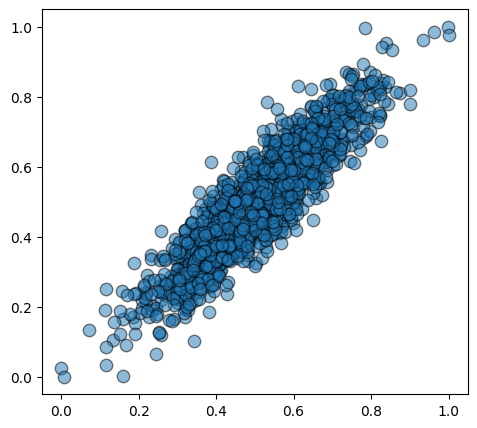

In [ ]:
np.random.seed(30091985)

rho = 0.9
train_D, test_D = generate_gaussian(rho)
train_D = scaler.fit_transform(train_D.T).T
test_D = scaler.fit_transform(test_D.T).T

visualize_data(train_D)

[tensor([1.9797, 0.6715, 0.4142, 0.5218, 1.3697, 1.4822, 0.6209, 1.8076, 0.0798,
        0.3222]), tensor([0.7091, 1.3206, 1.1522, 1.0457, 0.5767, 0.5828, 1.4192, 1.5190, 1.0023,
        0.6398])] [tensor([[0.4373, 0.1922, 0.3776, 0.7970, 0.1732, 0.6108, 0.7188, 0.2592, 0.9156,
         0.5061],
        [0.2842, 0.0727, 0.9258, 0.5158, 0.8309, 0.3427, 0.5020, 0.2472, 0.9547,
         0.1976],
        [0.6453, 0.3571, 0.4872, 0.4182, 0.0944, 0.0874, 0.5032, 0.2586, 0.2933,
         0.1570],
        [0.4428, 0.6908, 0.1095, 0.7723, 0.7763, 0.0347, 0.9911, 0.3479, 0.3704,
         0.0513],
        [0.1968, 0.7316, 0.2158, 0.8018, 0.5722, 0.6989, 0.9660, 0.5541, 0.7693,
         0.0144],
        [0.1190, 0.0435, 0.7401, 0.1151, 0.2069, 0.4515, 0.9458, 0.2245, 0.2046,
         0.3628],
        [0.0171, 0.2353, 0.3792, 0.5866, 0.5878, 0.6681, 0.9565, 0.3746, 0.5951,
         0.2179],
        [0.9338, 0.0319, 0.9687, 0.8625, 0.7348, 0.2495, 0.7277, 0.3025, 0.0307,
         0.7593],
        [0

<ipython-input-14-0cf8dd5cba73>:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  d = torch.tensor(data, requires_grad=True)


A saída de streaming foi truncada nas últimas 5000 linhas.
Training loss at epoch 194: -0.056734519173538986
Training loss at epoch 195: -0.05761633922385265
Training loss at epoch 196: -0.05747976417996806
Training loss at epoch 197: -0.05727124545858421
Training loss at epoch 198: -0.05758816675471349
Training loss at epoch 199: -0.05760657645643233
Training loss at epoch 200: -0.05848387426415422
Evaluating validation/test loss.
Average validation/test loss tensor(-0.0716, grad_fn=<NegBackward0>)
Training loss at epoch 201: -0.058354775599581465
Training loss at epoch 202: -0.058795836355421544
Training loss at epoch 203: -0.05986244858362298
Training loss at epoch 204: -0.05963953494754726
Training loss at epoch 205: -0.060304590116599555
Training loss at epoch 206: -0.060127013735185426
Training loss at epoch 207: -0.06027705440425317
Training loss at epoch 208: -0.060743423466666474
Training loss at epoch 209: -0.06095919731455454
Training loss at epoch 210: -0.06100447628596201


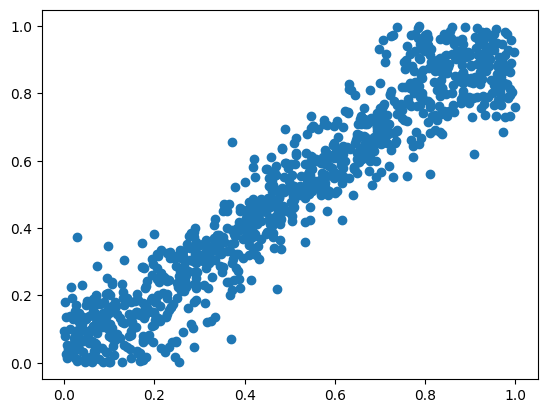

In [ ]:
train_data = torch.tensor(train_D).requires_grad_(True).T
test_data = torch.tensor(test_D).requires_grad_(True).T

phi = Phi(depth, widths, lc_w_range, shift_w_range)
net = Copula(phi)
yhat = expt(train_data, test_data, net, optim_name, optim_args, identifier_id, num_epochs, batch_size, chkpt_freq)

In [ ]:
yhat = -np.log(yhat.detach().numpy())
nll = np.mean(yhat)
res = bootstrap((yhat,), np.mean)
rmean = res.bootstrap_distribution.mean()
low = res.confidence_interval.low
high = res.confidence_interval.high
dev1 = high - rmean
dev2 = rmean - low
dev = dev1 if dev1 > dev2 else dev2
rmean, res.standard_error, res.confidence_interval
print(f'NLL: {nll:.4f} RMean: {rmean:.4f} IC: ({low:.4f},{high:.4f}) Notation: {rmean:.2f}$\pm${dev:.2f}')

NLL: -1.0534 RMean: -1.0531 IC: (-1.1244,-0.9747) Notation: -1.05$\pm$0.08


## Clayton $\theta = 1$

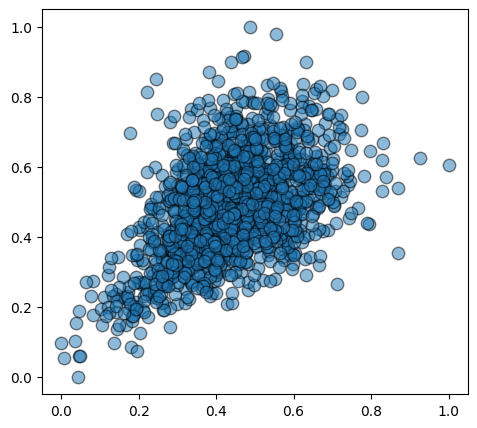

In [ ]:
np.random.seed(30091985)

theta = 1
train_D, test_D = generate_clayton_sample(theta)
train_D = scaler.fit_transform(train_D.T).T
test_D = scaler.fit_transform(test_D.T).T

visualize_data(train_D)

[tensor([1.4341, 0.4165, 0.6159, 0.0310, 1.7323, 1.4894, 1.9928, 1.0790, 0.9057,
        0.1546]), tensor([0.8736, 1.7779, 1.8461, 1.0480, 1.3337, 1.5212, 0.4474, 1.9759, 1.0488,
        0.6528])] [tensor([[0.1573, 0.6317, 0.1000, 0.0960, 0.6555, 0.3374, 0.1713, 0.8347, 0.8915,
         0.7569],
        [0.1222, 0.7456, 0.3539, 0.0089, 0.0618, 0.4695, 0.0193, 0.8402, 0.2204,
         0.7522],
        [0.6095, 0.2706, 0.1255, 0.7148, 0.7954, 0.5963, 0.8308, 0.7201, 0.0862,
         0.7841],
        [0.2289, 0.9902, 0.1164, 0.1491, 0.6463, 0.1040, 0.3607, 0.9627, 0.5333,
         0.4305],
        [0.0718, 0.9297, 0.6444, 0.0074, 0.1297, 0.3870, 0.8157, 0.8150, 0.1670,
         0.9458],
        [0.9228, 0.4794, 0.3616, 0.3955, 0.0490, 0.6032, 0.5099, 0.3671, 0.4090,
         0.4566],
        [0.0780, 0.8112, 0.0823, 0.5076, 0.7681, 0.8370, 0.9673, 0.1579, 0.9873,
         0.4810],
        [0.8820, 0.5932, 0.4096, 0.2374, 0.6022, 0.8948, 0.3620, 0.9106, 0.8587,
         0.6131],
        [0

<ipython-input-14-0cf8dd5cba73>:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  d = torch.tensor(data, requires_grad=True)


A saída de streaming foi truncada nas últimas 5000 linhas.
Training loss at epoch 194: -0.031700258068158585
Training loss at epoch 195: -0.032976691991335266
Training loss at epoch 196: -0.03186555456581559
Training loss at epoch 197: -0.032018168479722116
Training loss at epoch 198: -0.0321925715732324
Training loss at epoch 199: -0.03215792354668738
Training loss at epoch 200: -0.032976111108543565
Evaluating validation/test loss.
Average validation/test loss tensor(-0.0532, grad_fn=<NegBackward0>)
Training loss at epoch 201: -0.03310798788403819
Training loss at epoch 202: -0.03281627239911118
Training loss at epoch 203: -0.032740395519882975
Training loss at epoch 204: -0.0328796009989626
Training loss at epoch 205: -0.03354815036024561
Training loss at epoch 206: -0.03336322437196902
Training loss at epoch 207: -0.033537343397891176
Training loss at epoch 208: -0.03293734350888371
Training loss at epoch 209: -0.033526381241010324
Training loss at epoch 210: -0.034116912284608406


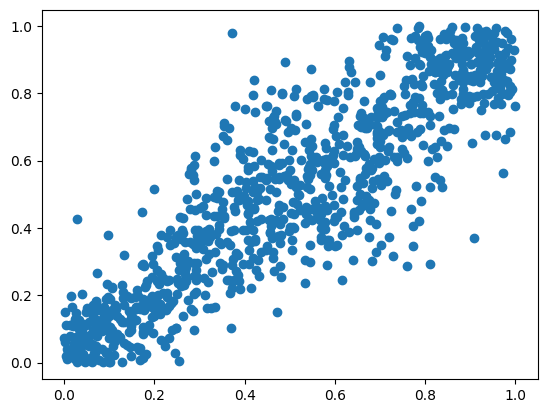

In [ ]:
train_data = torch.tensor(train_D).requires_grad_(True).T
test_data = torch.tensor(test_D).requires_grad_(True).T

phi = Phi(depth, widths, lc_w_range, shift_w_range)
net = Copula(phi)
yhat = expt(train_data, test_data, net, optim_name, optim_args, identifier_id, num_epochs, batch_size, chkpt_freq)

In [ ]:
yhat = -np.log(yhat.detach().numpy())
nll = np.mean(yhat)
res = bootstrap((yhat,), np.mean)
rmean = res.bootstrap_distribution.mean()
low = res.confidence_interval.low
high = res.confidence_interval.high
dev1 = high - rmean
dev2 = rmean - low
dev = dev1 if dev1 > dev2 else dev2
rmean, res.standard_error, res.confidence_interval
print(f'NLL: {nll:.4f} RMean: {rmean:.4f} IC: ({low:.4f},{high:.4f}) Notation: {rmean:.2f}$\pm${dev:.2f}')

NLL: -0.5144 RMean: -0.5147 IC: (-0.5688,-0.4488) Notation: -0.51$\pm$0.07


## Clayton $\theta = 5$

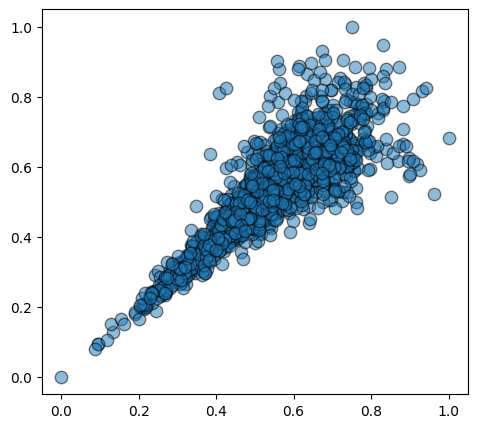

In [ ]:
np.random.seed(30091985)

theta = 5
train_D, test_D = generate_clayton_sample(theta)
train_D = scaler.fit_transform(train_D.T).T
test_D = scaler.fit_transform(test_D.T).T

visualize_data(train_D)

[tensor([0.2335, 0.5359, 1.9636, 0.4088, 0.7958, 0.0146, 1.7896, 1.4882, 1.7091,
        0.0187]), tensor([1.6676, 0.6167, 0.0381, 0.7811, 1.6565, 1.3314, 1.0787, 1.8917, 0.3527,
        0.9448])] [tensor([[0.0483, 0.7730, 0.9670, 0.1853, 0.0503, 0.8801, 0.1100, 0.6884, 0.9745,
         0.8030],
        [0.5930, 0.7102, 0.0407, 0.4508, 0.9513, 0.6310, 0.6587, 0.8347, 0.5854,
         0.1160],
        [0.9137, 0.4405, 0.6792, 0.5696, 0.7473, 0.0952, 0.6302, 0.0714, 0.4883,
         0.4024],
        [0.7424, 0.8087, 0.8881, 0.0739, 0.0936, 0.4095, 0.9970, 0.1001, 0.7522,
         0.8591],
        [0.8632, 0.5111, 0.5467, 0.9591, 0.8643, 0.8245, 0.8559, 0.5299, 0.5108,
         0.2167],
        [0.8964, 0.6867, 0.2704, 0.2355, 0.6039, 0.4750, 0.1686, 0.5892, 0.7302,
         0.1089],
        [0.4633, 0.4673, 0.1897, 0.6308, 0.3064, 0.9679, 0.4012, 0.0365, 0.7482,
         0.7598],
        [0.6727, 0.7557, 0.2074, 0.3013, 0.9449, 0.2739, 0.8822, 0.9659, 0.1524,
         0.9932],
        [0

<ipython-input-14-0cf8dd5cba73>:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  d = torch.tensor(data, requires_grad=True)


A saída de streaming foi truncada nas últimas 5000 linhas.
Training loss at epoch 194: -0.0917173401919397
Training loss at epoch 195: -0.09245768818178932
Training loss at epoch 196: -0.09238105082933983
Training loss at epoch 197: -0.09275018960169157
Training loss at epoch 198: -0.09275558930616051
Training loss at epoch 199: -0.094047836396974
Training loss at epoch 200: -0.09568902912417718
Evaluating validation/test loss.
Average validation/test loss tensor(-0.1094, grad_fn=<NegBackward0>)
Training loss at epoch 201: -0.09425771102532725
Training loss at epoch 202: -0.09490061974058676
Training loss at epoch 203: -0.09534662957719504
Training loss at epoch 204: -0.09552887606759342
Training loss at epoch 205: -0.09788926880192095
Training loss at epoch 206: -0.09646543088892359
Training loss at epoch 207: -0.0988618945290955
Training loss at epoch 208: -0.09815014548580911
Training loss at epoch 209: -0.09742149491079741
Training loss at epoch 210: -0.09801039469085457
Training l

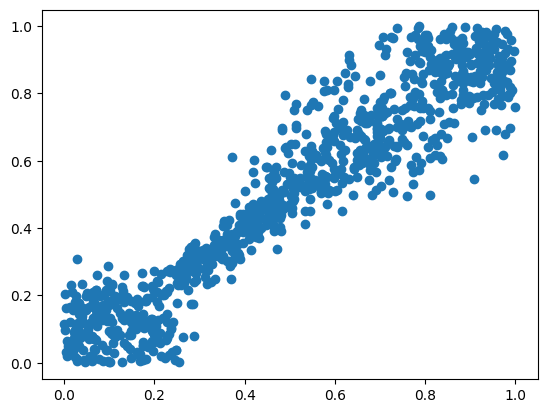

In [ ]:
train_data = torch.tensor(train_D).requires_grad_(True).T
test_data = torch.tensor(test_D).requires_grad_(True).T

phi = Phi(depth, widths, lc_w_range, shift_w_range)
net = Copula(phi)
yhat = expt(train_data, test_data, net, optim_name, optim_args, identifier_id, num_epochs, batch_size, chkpt_freq)

In [ ]:
yhat = -np.log(yhat.detach().numpy())
nll = np.mean(yhat)
res = bootstrap((yhat,), np.mean)
rmean = res.bootstrap_distribution.mean()
low = res.confidence_interval.low
high = res.confidence_interval.high
dev1 = high - rmean
dev2 = rmean - low
dev = dev1 if dev1 > dev2 else dev2
rmean, res.standard_error, res.confidence_interval
print(f'NLL: {nll:.4f} RMean: {rmean:.4f} IC: ({low:.4f},{high:.4f}) Notation: {rmean:.2f}$\pm${dev:.2f}')

NLL: -0.9125 RMean: -0.9130 IC: (-1.0148,-0.7999) Notation: -0.91$\pm$0.11


## Clayton $\theta = 10$

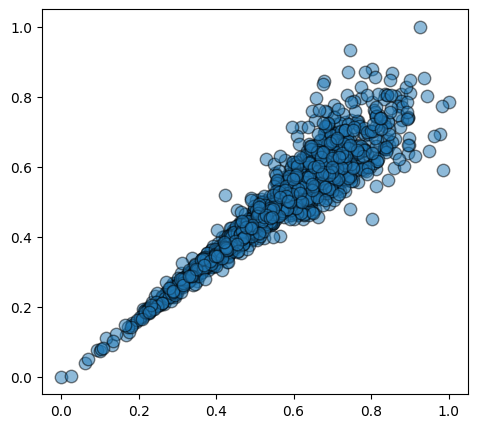

In [ ]:
np.random.seed(30091985)

theta = 10
train_D, test_D = generate_clayton_sample(theta)
train_D = scaler.fit_transform(train_D.T).T
test_D = scaler.fit_transform(test_D.T).T

visualize_data(train_D)

[tensor([0.2938, 0.5684, 0.2268, 1.9503, 0.1140, 1.8143, 1.5132, 1.4491, 1.0686,
        0.9749]), tensor([0.8682, 0.0118, 0.5475, 1.7049, 1.4190, 0.0243, 1.3233, 1.4519, 0.9917,
        1.0218])] [tensor([[0.5669, 0.4046, 0.5546, 0.5529, 0.9248, 0.9780, 0.3445, 0.2946, 0.5917,
         0.1410],
        [0.9279, 0.4724, 0.5683, 0.1073, 0.2287, 0.0744, 0.3296, 0.0346, 0.0355,
         0.4494],
        [0.7143, 0.7369, 0.3633, 0.7933, 0.7106, 0.9235, 0.8034, 0.2198, 0.1029,
         0.7905],
        [0.7610, 0.8813, 0.4686, 0.7237, 0.1700, 0.2680, 0.4615, 0.3764, 0.6192,
         0.2345],
        [0.8279, 0.1583, 0.7067, 0.0512, 0.7851, 0.4089, 0.0141, 0.1885, 0.3566,
         0.5062],
        [0.8976, 0.7928, 0.3633, 0.7700, 0.5398, 0.5633, 0.5262, 0.4037, 0.4690,
         0.0030],
        [0.3426, 0.4315, 0.0931, 0.6135, 0.5839, 0.4706, 0.8100, 0.4434, 0.9963,
         0.9395],
        [0.5235, 0.3010, 0.7483, 0.6263, 0.3060, 0.9338, 0.2121, 0.4140, 0.4878,
         0.5848],
        [0

<ipython-input-14-0cf8dd5cba73>:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  d = torch.tensor(data, requires_grad=True)


A saída de streaming foi truncada nas últimas 5000 linhas.
Training loss at epoch 194: -0.08030100008755198
Training loss at epoch 195: -0.08052408543061071
Training loss at epoch 196: -0.08068717934176273
Training loss at epoch 197: -0.08194826853132958
Training loss at epoch 198: -0.08138639261311101
Training loss at epoch 199: -0.08179317552514831
Training loss at epoch 200: -0.08213910977367848
Evaluating validation/test loss.
Average validation/test loss tensor(-0.1107, grad_fn=<NegBackward0>)
Training loss at epoch 201: -0.08226622622811808
Training loss at epoch 202: -0.08335294936694616
Training loss at epoch 203: -0.08410290799384401
Training loss at epoch 204: -0.08641924171749499
Training loss at epoch 205: -0.08370821687462696
Training loss at epoch 206: -0.08460850949091414
Training loss at epoch 207: -0.08536550639336349
Training loss at epoch 208: -0.08635451721906649
Training loss at epoch 209: -0.08625964398046457
Training loss at epoch 210: -0.08671621052872207
Traini

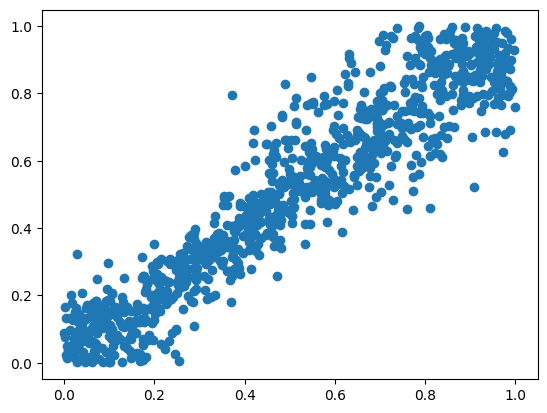

In [ ]:
train_data = torch.tensor(train_D).requires_grad_(True).T
test_data = torch.tensor(test_D).requires_grad_(True).T

phi = Phi(depth, widths, lc_w_range, shift_w_range)
net = Copula(phi)
yhat = expt(train_data, test_data, net, optim_name, optim_args, identifier_id, num_epochs, batch_size, chkpt_freq)

In [ ]:
yhat = -np.log(yhat.detach().numpy())
nll = np.mean(yhat)
res = bootstrap((yhat,), np.mean)
rmean = res.bootstrap_distribution.mean()
low = res.confidence_interval.low
high = res.confidence_interval.high
dev1 = high - rmean
dev2 = rmean - low
dev = dev1 if dev1 > dev2 else dev2
rmean, res.standard_error, res.confidence_interval
print(f'NLL: {nll:.4f} RMean: {rmean:.4f} IC: ({low:.4f},{high:.4f}) Notation: {rmean:.2f}$\pm${dev:.2f}')

NLL: -1.3453 RMean: -1.3452 IC: (-1.3853,-1.3006) Notation: -1.35$\pm$0.04


## Frank $\theta = 1$

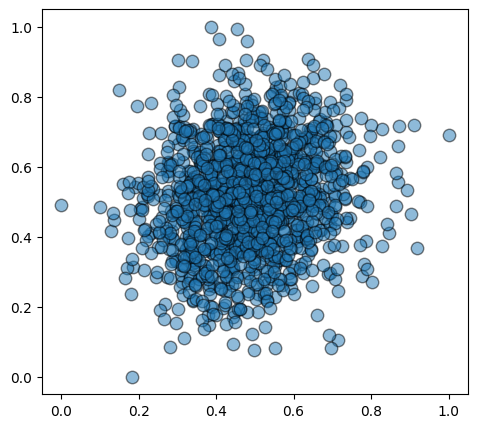

In [ ]:
np.random.seed(30091985)

theta = 1
train_D, test_D = generate_frank_sample(theta)
train_D = scaler.fit_transform(train_D.T).T
test_D = scaler.fit_transform(test_D.T).T

visualize_data(train_D)

[tensor([1.1797, 0.9374, 0.7893, 1.4311, 1.9230, 0.5121, 0.5826, 0.2227, 1.3626,
        0.5168]), tensor([0.2221, 0.4161, 1.3384, 0.5443, 0.1775, 0.2536, 0.0288, 0.6477, 0.0242,
        0.3352])] [tensor([[0.8801, 0.5606, 0.9267, 0.5174, 0.7046, 0.3243, 0.1597, 0.9575, 0.7643,
         0.4761],
        [0.0551, 0.4793, 0.8767, 0.5885, 0.4440, 0.1048, 0.4286, 0.6572, 0.0293,
         0.5722],
        [0.9785, 0.6899, 0.9787, 0.9011, 0.6576, 0.8742, 0.5835, 0.1245, 0.2390,
         0.2955],
        [0.2378, 0.7308, 0.5308, 0.0109, 0.9956, 0.1281, 0.4521, 0.5977, 0.1531,
         0.6275],
        [0.5422, 0.8501, 0.5383, 0.5368, 0.2631, 0.8655, 0.0344, 0.5018, 0.6567,
         0.0770],
        [0.7703, 0.6648, 0.7184, 0.1494, 0.6788, 0.2186, 0.9657, 0.6581, 0.6769,
         0.4650],
        [0.2906, 0.4388, 0.2419, 0.6881, 0.9012, 0.4510, 0.6733, 0.8716, 0.4496,
         0.8348],
        [0.7702, 0.6820, 0.9629, 0.6100, 0.9946, 0.3135, 0.3605, 0.3107, 0.6424,
         0.2790],
        [0

<ipython-input-14-0cf8dd5cba73>:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  d = torch.tensor(data, requires_grad=True)


A saída de streaming foi truncada nas últimas 5000 linhas.
Training loss at epoch 194: -0.01294852783531738
Training loss at epoch 195: -0.013049403653472081
Training loss at epoch 196: -0.013362266903745255
Training loss at epoch 197: -0.013119278058320851
Training loss at epoch 198: -0.013367929514175918
Training loss at epoch 199: -0.013500420579601134
Training loss at epoch 200: -0.01338994149996709
Evaluating validation/test loss.
Average validation/test loss tensor(-0.0072, grad_fn=<NegBackward0>)
Training loss at epoch 201: -0.01377656525419831
Training loss at epoch 202: -0.013401783062737156
Training loss at epoch 203: -0.013356612440279511
Training loss at epoch 204: -0.013759770276440417
Training loss at epoch 205: -0.013617395508567075
Training loss at epoch 206: -0.013136587372618025
Training loss at epoch 207: -0.013439936608146468
Training loss at epoch 208: -0.013607910096147233
Training loss at epoch 209: -0.01365714479307089
Training loss at epoch 210: -0.013749933861

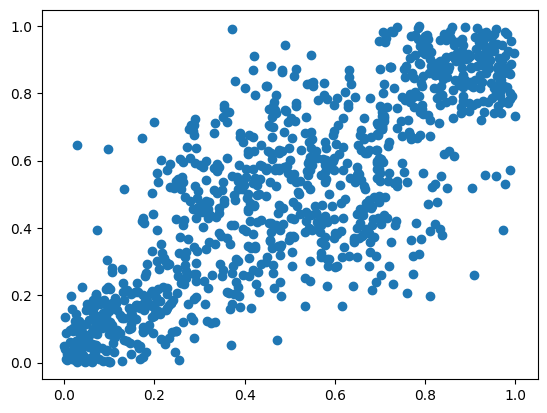

In [ ]:
train_data = torch.tensor(train_D).requires_grad_(True).T
test_data = torch.tensor(test_D).requires_grad_(True).T

phi = Phi(depth, widths, lc_w_range, shift_w_range)
net = Copula(phi)
yhat = expt(train_data, test_data, net, optim_name, optim_args, identifier_id, num_epochs, batch_size, chkpt_freq)

In [ ]:
yhat = -np.log(yhat.detach().numpy())
nll = np.mean(yhat)
res = bootstrap((yhat,), np.mean)
rmean = res.bootstrap_distribution.mean()
low = res.confidence_interval.low
high = res.confidence_interval.high
dev1 = high - rmean
dev2 = rmean - low
dev = dev1 if dev1 > dev2 else dev2
rmean, res.standard_error, res.confidence_interval
print(f'NLL: {nll:.4f} RMean: {rmean:.4f} IC: ({low:.4f},{high:.4f}) Notation: {rmean:.2f}$\pm${dev:.2f}')

NLL: -0.1253 RMean: -0.1256 IC: (-0.1993,-0.0374) Notation: -0.13$\pm$0.09


## Frank $\theta = 5$

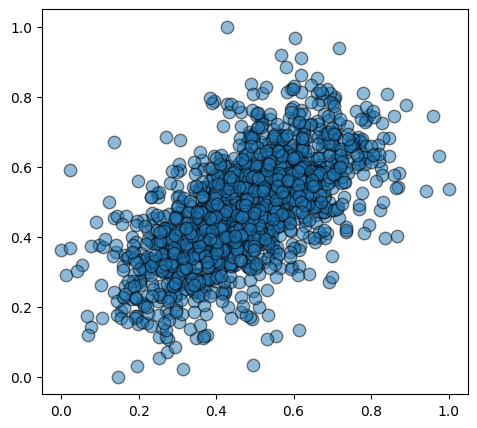

In [ ]:
np.random.seed(30091985)

theta = 5
train_D, test_D = generate_frank_sample(theta)
train_D = scaler.fit_transform(train_D.T).T
test_D = scaler.fit_transform(test_D.T).T

visualize_data(train_D)

[tensor([0.6193, 0.5573, 0.2098, 0.7449, 0.1329, 1.0854, 0.1577, 0.2301, 1.4073,
        0.0408]), tensor([1.7855, 1.6297, 0.5188, 0.5570, 1.1603, 0.7818, 1.6876, 1.9292, 0.6097,
        1.3391])] [tensor([[2.8990e-01, 1.6744e-01, 9.2504e-01, 8.0346e-01, 9.4130e-02, 3.2611e-01,
         2.6040e-01, 5.6036e-01, 7.4604e-01, 3.8530e-01],
        [7.9790e-01, 7.5703e-01, 4.2717e-03, 5.6409e-01, 3.7920e-01, 6.8400e-02,
         7.2052e-01, 6.4291e-01, 1.9993e-01, 4.7125e-01],
        [1.1168e-01, 2.8909e-01, 2.8185e-02, 1.5949e-01, 7.8454e-01, 9.1012e-01,
         2.6721e-01, 5.8774e-01, 9.2942e-01, 9.4678e-03],
        [9.5134e-01, 2.2052e-01, 5.0269e-01, 8.5856e-01, 5.4020e-01, 2.5136e-01,
         7.3984e-01, 2.1979e-01, 9.9892e-01, 1.1504e-01],
        [3.6336e-01, 2.4441e-01, 2.6195e-01, 9.1015e-02, 6.4109e-01, 2.7192e-01,
         3.9605e-02, 3.4150e-01, 5.3748e-01, 6.1348e-01],
        [9.7010e-01, 8.3551e-01, 2.8865e-01, 1.2242e-02, 3.6580e-01, 3.6280e-01,
         8.5589e-02, 3.615

<ipython-input-14-0cf8dd5cba73>:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  d = torch.tensor(data, requires_grad=True)


A saída de streaming foi truncada nas últimas 5000 linhas.
Training loss at epoch 194: -0.049135163201127346
Training loss at epoch 195: -0.04953980093652882
Training loss at epoch 196: -0.04993246306922235
Training loss at epoch 197: -0.050188093947296716
Training loss at epoch 198: -0.05092760966327445
Training loss at epoch 199: -0.051663279689522466
Training loss at epoch 200: -0.05071850438511736
Evaluating validation/test loss.
Average validation/test loss tensor(-0.0535, grad_fn=<NegBackward0>)
Training loss at epoch 201: -0.05162840500334067
Training loss at epoch 202: -0.05170352559306339
Training loss at epoch 203: -0.052486096461755685
Training loss at epoch 204: -0.053066064683637955
Training loss at epoch 205: -0.05321505070469187
Training loss at epoch 206: -0.05353453517340991
Training loss at epoch 207: -0.05390596958282421
Training loss at epoch 208: -0.05464620344239324
Training loss at epoch 209: -0.05496237994618046
Training loss at epoch 210: -0.05489240932979229
T

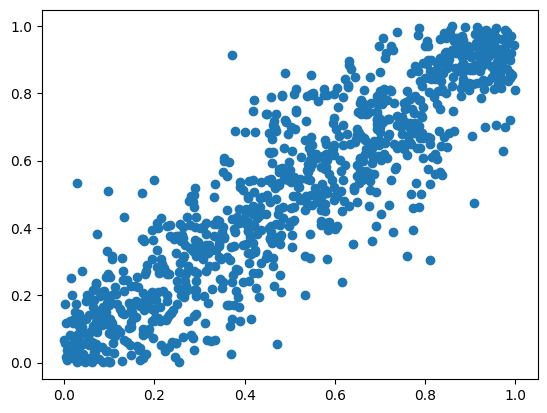

In [ ]:
train_data = torch.tensor(train_D).requires_grad_(True).T
test_data = torch.tensor(test_D).requires_grad_(True).T

phi = Phi(depth, widths, lc_w_range, shift_w_range)
net = Copula(phi)
yhat = expt(train_data, test_data, net, optim_name, optim_args, identifier_id, num_epochs, batch_size, chkpt_freq)

In [ ]:
yhat = -np.log(yhat.detach().numpy())
nll = np.mean(yhat)
res = bootstrap((yhat,), np.mean)
rmean = res.bootstrap_distribution.mean()
low = res.confidence_interval.low
high = res.confidence_interval.high
dev1 = high - rmean
dev2 = rmean - low
dev = dev1 if dev1 > dev2 else dev2
rmean, res.standard_error, res.confidence_interval
print(f'NLL: {nll:.4f} RMean: {rmean:.4f} IC: ({low:.4f},{high:.4f}) Notation: {rmean:.2f}$\pm${dev:.2f}')

NLL: -0.4919 RMean: -0.4913 IC: (-0.5653,-0.4094) Notation: -0.49$\pm$0.08


## Frank $\theta = 10$

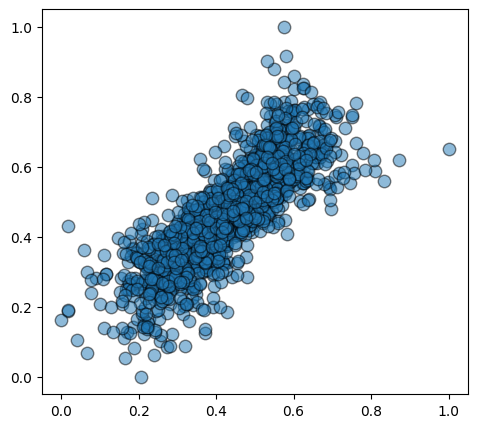

In [ ]:
np.random.seed(30091985)

theta = 10
train_D, test_D = generate_frank_sample(theta)
train_D = scaler.fit_transform(train_D.T).T
test_D = scaler.fit_transform(test_D.T).T

visualize_data(train_D)

[tensor([1.6993, 0.1358, 1.9076, 0.9851, 1.0324, 0.9098, 1.1032, 1.6645, 1.7702,
        1.5119]), tensor([1.6136, 0.2202, 0.6136, 1.1066, 0.2070, 0.6009, 1.3181, 0.3319, 0.3834,
        1.5758])] [tensor([[0.4832, 0.9606, 0.0238, 0.7060, 0.0775, 0.1125, 0.8542, 0.7806, 0.0022,
         0.5526],
        [0.7908, 0.7275, 0.5846, 0.6332, 0.6453, 0.7845, 0.1195, 0.3317, 0.0782,
         0.5433],
        [0.9457, 0.8974, 0.6700, 0.9174, 0.3602, 0.3269, 0.7438, 0.5671, 0.8429,
         0.3173],
        [0.8822, 0.1554, 0.2330, 0.7760, 0.9564, 0.9628, 0.4451, 0.3060, 0.9547,
         0.3533],
        [0.6211, 0.0289, 0.9112, 0.8299, 0.5794, 0.7812, 0.8588, 0.8850, 0.1168,
         0.8076],
        [0.4529, 0.2562, 0.2908, 0.6565, 0.4187, 0.3671, 0.7066, 0.4933, 0.2324,
         0.0758],
        [0.4872, 0.5252, 0.2734, 0.6689, 0.9956, 0.9376, 0.9727, 0.1410, 0.3050,
         0.4005],
        [0.3897, 0.2352, 0.8027, 0.3245, 0.7252, 0.7085, 0.3359, 0.6989, 0.3489,
         0.9469],
        [0

<ipython-input-14-0cf8dd5cba73>:47: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  d = torch.tensor(data, requires_grad=True)


A saída de streaming foi truncada nas últimas 5000 linhas.
Training loss at epoch 194: -0.02985838183412171
Training loss at epoch 195: -0.030740610622529994
Training loss at epoch 196: -0.030494409263488814
Training loss at epoch 197: -0.030192573763180554
Training loss at epoch 198: -0.030645554336655872
Training loss at epoch 199: -0.030677538807630016
Training loss at epoch 200: -0.030405709278793422
Evaluating validation/test loss.
Average validation/test loss tensor(-0.0348, grad_fn=<NegBackward0>)
Training loss at epoch 201: -0.030791876511120954
Training loss at epoch 202: -0.03126150718138117
Training loss at epoch 203: -0.031195038217991845
Training loss at epoch 204: -0.030967303674034934
Training loss at epoch 205: -0.03118199004239587
Training loss at epoch 206: -0.031207284890108142
Training loss at epoch 207: -0.03141329243755309
Training loss at epoch 208: -0.03168285808537159
Training loss at epoch 209: -0.03180823955882395
Training loss at epoch 210: -0.03180066959630

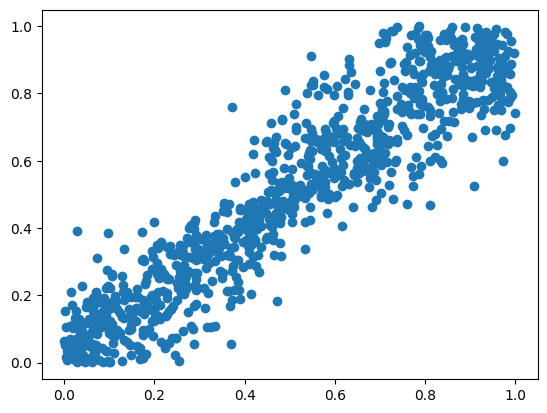

In [ ]:
train_data = torch.tensor(train_D).requires_grad_(True).T
test_data = torch.tensor(test_D).requires_grad_(True).T

phi = Phi(depth, widths, lc_w_range, shift_w_range)
net = Copula(phi)
yhat = expt(train_data, test_data, net, optim_name, optim_args, identifier_id, num_epochs, batch_size, chkpt_freq)

In [ ]:
yhat = -np.log(yhat.detach().numpy())
nll = np.mean(yhat)
res = bootstrap((yhat,), np.mean)
rmean = res.bootstrap_distribution.mean()
low = res.confidence_interval.low
high = res.confidence_interval.high
dev1 = high - rmean
dev2 = rmean - low
dev = dev1 if dev1 > dev2 else dev2
rmean, res.standard_error, res.confidence_interval
print(f'NLL: {nll:.4f} RMean: {rmean:.4f} IC: ({low:.4f},{high:.4f}) Notation: {rmean:.2f}$\pm${dev:.2f}')

NLL: -0.5755 RMean: -0.5756 IC: (-0.6677,-0.4762) Notation: -0.58$\pm$0.10
